# Exercise 9: Wiener Filter for Noise Supression

In [2]:
%matplotlib inline
import numpy as np
from mel_filterbank import mel_filterbank
from scipy.io.wavfile import read
from scipy.signal import get_window, spectrogram
from IPython.display import Audio, display
from numpy.fft import rfft, irfft
import matplotlib.pyplot as plt

In [3]:
def mel_smooth_gain(gain, mel_bank, mel_range):
    smooth_gain = np.zeros_like(gain)
    for k in range(len(gain)):
        low_bin, high_bin  = mel_range[k]
        bound = high_bin - low_bin
        smooth_gain[k] = gain[low_bin:high_bin] @ mel_bank[k, :bound]
    return smooth_gain

In [4]:
def plot_spectrogram(signal, name, sample_rate, fft_length, floor_val=-90):
    floor_val = 10**(floor_val/10)
    plt.figure(figsize=(15, 6))
    f, t, S = spectrogram(signal, fs=sample_rate, nperseg=fft_length,
                          noverlap=fft_length//2, window='hamming')
    plt.pcolormesh(t, f, 10*np.log10(np.maximum(S, floor_val)))
    plt.xlabel(r'$t / \,\mathrm{s}$', fontsize=15)
    plt.ylabel(r'$f / \,\mathrm{Hz}$', fontsize=15)
    plt.title(name, fontsize=20)

## Define constants

In [5]:
fft_length = 512
shift = fft_length//2
nyquist_bin = fft_length//2 + 1
sample_rate = 16000

SNR = 15.  # in dB

## Load input audio file

In [6]:
sample_rate_in, clean_sound = read('fg_nt_upb_16k.wav')
assert sample_rate_in == sample_rate
clean_sound = clean_sound.astype(np.float) / np.max(clean_sound)

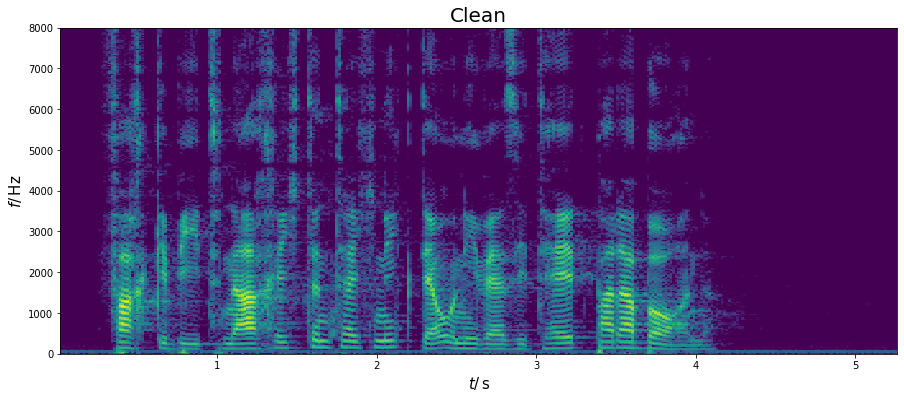

In [7]:
display(Audio(clean_sound, rate=16000))
plot_spectrogram(clean_sound, 'Clean', sample_rate, fft_length)

## Corrupt with additive noise

In [8]:
noise = np.random.normal(size=clean_sound.size)
noise_power = np.std(noise)
signal_power = np.std(clean_sound)
signal_amplitude = np.sqrt((noise_power/signal_power) * 10**(SNR/10.))
noisy_sound = signal_amplitude * clean_sound + noise

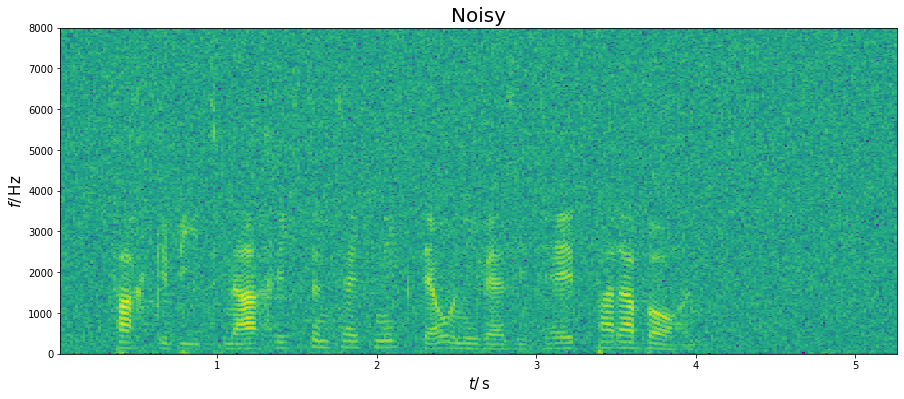

In [9]:
display(Audio(noisy_sound, rate=16000))
plot_spectrogram(noisy_sound, 'Noisy', sample_rate, fft_length)

## Algorithm Hyperparameters

In [10]:
power_spectral_domain = True
smooth_mel = True

start_speech_block = 22 # keep this fixed!

gain_smooth = 0.9
min_gain = 0.01

if power_spectral_domain:
    alpha, beta, gamma = 2, 1/2, 1.0
else:
    alpha, beta, gamma = 1., 1., 1.

num_mel_channels = 10
eps = 1e-12

## Get mel-smoothing filterbank

In [14]:
mel_range, mel_bank = mel_filterbank(sample_rate, num_mel_channels, fft_length)
mel_range, mel_bank

([(1, 7),
  (1, 8),
  (1, 9),
  (1, 10),
  (1, 12),
  (1, 13),
  (1, 14),
  (2, 15),
  (3, 16),
  (4, 17),
  (5, 18),
  (5, 19),
  (6, 21),
  (7, 22),
  (8, 23),
  (9, 24),
  (10, 25),
  (11, 26),
  (12, 27),
  (12, 29),
  (13, 30),
  (14, 31),
  (15, 32),
  (16, 33),
  (17, 34),
  (18, 35),
  (19, 37),
  (19, 38),
  (20, 39),
  (21, 40),
  (22, 41),
  (23, 42),
  (24, 43),
  (25, 44),
  (26, 46),
  (27, 47),
  (27, 48),
  (28, 49),
  (29, 50),
  (30, 51),
  (31, 52),
  (32, 54),
  (33, 55),
  (34, 56),
  (34, 57),
  (35, 58),
  (36, 59),
  (37, 60),
  (38, 61),
  (39, 63),
  (40, 64),
  (41, 65),
  (42, 66),
  (42, 67),
  (43, 68),
  (44, 69),
  (45, 71),
  (46, 72),
  (47, 73),
  (48, 74),
  (49, 75),
  (49, 76),
  (50, 77),
  (51, 78),
  (52, 80),
  (53, 81),
  (54, 82),
  (55, 83),
  (56, 84),
  (57, 85),
  (57, 86),
  (58, 88),
  (59, 89),
  (60, 90),
  (61, 91),
  (62, 92),
  (63, 93),
  (64, 94),
  (64, 95),
  (65, 97),
  (66, 98),
  (67, 99),
  (68, 100),
  (69, 101),
  (70, 10

## Spectral subtraction

In [11]:
num_blocks = int(len(noisy_sound)//shift+1)

# pad input with zeros 
pad_length = int((num_blocks - 1)*shift + fft_length - len(noisy_sound))
noisy_sound = np.append(noisy_sound, np.zeros(pad_length))
prev_gain = np.zeros(nyquist_bin) # previous gain for smoothing
output = np.zeros(noisy_sound.size)
output_spectrum = np.zeros(nyquist_bin)
noise_mag_spectrum = np.zeros(nyquist_bin) # averaged magnitude spectrum of noise

w = get_window('hamming', fft_length)

for m in range(num_blocks):
    # FFT of input signal
    input_spectrum  = rfft(noisy_sound[m*shift:m*shift+fft_length] * w, fft_length)
    input_spectrum = input_spectrum[:nyquist_bin]
    input_mag_spectrum = np.abs(input_spectrum)
    # noise spectrum estimation on first blocks (assuming no speech present!)
    if m < start_speech_block:
        # recursive update of arithmetic mean over time
        noise_mag_spectrum = (input_mag_spectrum + m*noise_mag_spectrum)/(m+1)  # REPLACE noise_mag_spectrum = # TODO
    
    # Calculate gain using alpha, beta, noise_mag_spectrum and input_block
    gain = np.maximum(1 - gamma*(noise_mag_spectrum/(input_mag_spectrum + eps))**alpha, 0)**beta  # REPLACE gain = # TODO
    
    # Gain limiting between min_gain and 1
    gain = np.minimum(np.maximum(gain, min_gain), 1)  # REPLACE gain = # TODO
    
    if smooth_mel:
        gain = mel_smooth_gain(gain, mel_bank, mel_range)

    
    # Filtering
    output_spectrum = input_spectrum * gain  # REPLACE output_spectrum = # TODO

    # Transformation to time domain
    output_block = irfft(output_spectrum, fft_length).real
    
    # Overlap-add
    output[m*shift:m*shift+fft_length] += output_block
# remove padding
output = output[:len(clean_sound)]

## Show result

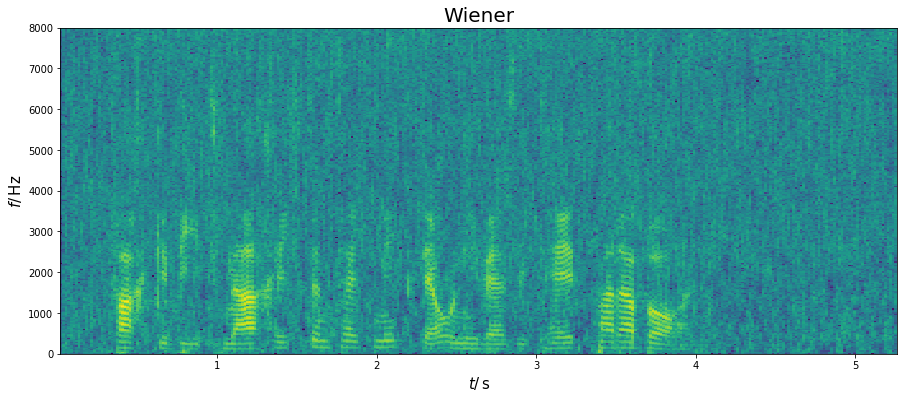

In [12]:
display(Audio(output, rate=16000))
plot_spectrogram(output, 'Wiener', sample_rate, fft_length)

## Extra Credit
Try to implement the Decision Directed Approach based on a priori and a posteriori SNR estimates from the lecture.
- Copy the spectral subtraction algorithm and the Result block first
- Do an average over the first 22 blocks for noise psd spectrum estimation instead of the way it is done in the lecture

In [13]:
beta_prio = 0.95  # REPLACE beta_prio = # TODO
smooth_mel_dd = True  # REPLACE smooth_mel_dd = # TODO

In [14]:
# REPLACE # TODO: Decision directed approach
num_blocks = int(len(noisy_sound)//shift+1)

# pad input with zeros 
pad_length = int((num_blocks - 1)*shift + fft_length - len(noisy_sound))
noisy_sound = np.append(noisy_sound, np.zeros(pad_length))
prev_gain = np.zeros(nyquist_bin) # previous gain for smoothing
output = np.zeros(noisy_sound.size)
output_spectrum = np.zeros(nyquist_bin)
noise_psd = np.zeros(nyquist_bin) # averaged magnitude spectrum of noise

w = get_window('hamming', fft_length)

for m in range(num_blocks):
    # FFT of input signal
    input_spectrum  = rfft(noisy_sound[m*shift:m*shift+fft_length] * w, fft_length)
    input_spectrum = input_spectrum[:nyquist_bin]
    input_mag_spectrum = np.abs(input_spectrum)
    # noise spectrum estimation on first blocks (assuming no speech present!)
    if m < start_speech_block:
        # recursive update of arithmetic mean over time
        # Note: This is still estimated as before since only the first 22 blocks are used!
        noise_psd = (m*noise_psd + input_mag_spectrum**2)/(m+1)
    
    # Calculate gain with Decision Directed Approach
    snr_post = (input_mag_spectrum**2/(noise_psd + eps))
    snr_prio = ( (1-beta_prio)*np.maximum(snr_post - 1, 0) 
                + beta_prio * np.abs(output_spectrum)**2/(noise_psd + eps) )
    # Recursive smoothing over time
    gain = snr_prio/(1 + snr_prio)
    
    if smooth_mel_dd:
        gain = mel_smooth_gain(gain, mel_bank, mel_range)

    
    # Filtering
    output_spectrum = input_spectrum * gain

    # Transformation to time domain
    output_block = irfft(output_spectrum, fft_length).real
    
    # Overlap-add
    output[m*shift:m*shift+fft_length] += output_block
# remove padding
output = output[:len(clean_sound)]

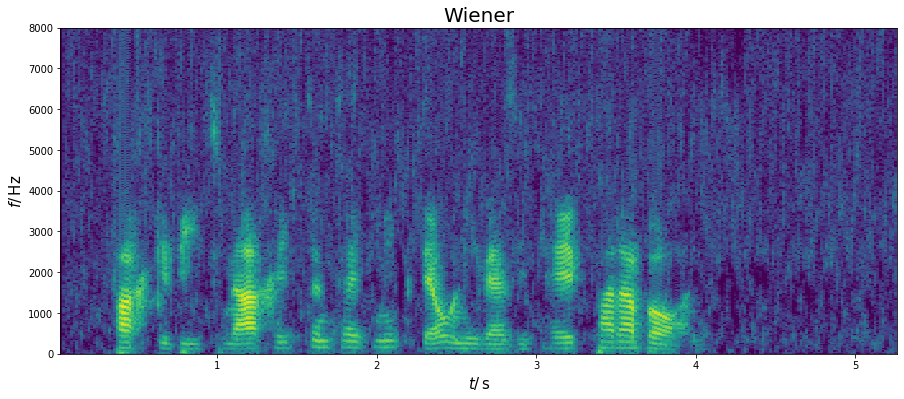

In [15]:
display(Audio(output, rate=16000))
plot_spectrogram(output, 'Wiener', sample_rate, fft_length)